$$
\large \textbf{Problema 01}
$$

Se tiene una placa cuadrada de aluminio cuyos bordes están en las condiciones que se indican en la figura: tres lados a temperaturas fijas y otro, el inferior, aislado térmicamente (flujo de calor igual a cero). Encuentre, utilizando el método de diferencias finitas, los valores de temperatura y flujo de calor para cada punto. Utilice primero la grilla señalada y luego generalice el problema a un número variable de nodos en cada eje de coordenadas. Haga un estudio del tiempo de cálculo en función del tamaño del sistema.
<center><img src="ImgProb01.png"></center>

***

In [1]:
import numpy as np                # Librería de álgebra lineal
import matplotlib.pyplot as plt   # Librería de gráficos
plt.rc('figure', figsize=(15,8))
plt.rc('font', size=16)
import time

La ecuación diferencial que rige el problema es la ecuación de Poison, que es la ecuación de transferencia térmica homogénea:

$$
\frac{\partial^2 T_{(x,y)}}{\partial x^2}+\frac{\partial^2 T_{(x,y)}}{\partial y^2}=0
$$

Debido a que los contornos del recinto donde debemos resolver la ecuación de Poison son los adecuados, se utiliza el método de diferencias finitas. Según este método, deben usarse las versiones discretas de las derivadas segundas en la ecuación de Poison:

$$
\left. \frac{\partial^2 T}{\partial x^2} \right|_k = \frac{T_{k+1}-2\:T_k+T_{k-1}}{\Delta x^2}
\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:;\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:
\left. \frac{\partial^2 T}{\partial y^2} \right|_k = \frac{T_{k+N_x}-2\:T_k+T_{k-N_y}}{\Delta y^2}
$$

## Datos del problema
La chapa tiene $N=N_xN_y$ nodos y las condiciones de contorno dadas por el problema.

In [2]:
Nx = 100
Ny = 100
N = Nx*Ny

CC = {'A':75, 'B':0, 'C':50, 'D':100}
TipoCC = {'A':'Temp', 'B':'Heat', 'C':'Temp', 'D':'Temp'}

Es conveniente que la numeración de los nodos sea en función de un único índice $k$, de modo que las temperaturas puedan representarse en un vector $\bar{T} = \left( T_1,\:T_2,\:\cdots,\:T_N \right)$. Contando de izquierda a derecha y de abajo a arriba, los vértices son:

- Inferior izquierdo: $k=0$

- Inferior derecho:   $k=N_x-1$
- Superior derecho:   $k=N-1$
- Superior izquierdo: $k=N-N_x$

## Matricialización

Para el conjunto de nodos del interior de la chapa:

$$
\beta^2\:T_{k-N_x} + T_{k-1} - 2\:(1+\beta^2)\:T_k + T_{k+1} + \beta^2\:T_{k+N_x} = 0
$$

donde se ha definido $\beta = \frac{\Delta x}{\Delta y}$. Esto puede reescribirse como:

$$
\begin{bmatrix} \beta^2 & 1 & 2 \:(1+\beta^2) & 1 & \beta^2 \end{bmatrix} \:\bullet\: \begin{bmatrix} T_{k-N_x} \\ T_{k-1} \\ T_k \\ T_{k+1} \\ T_{k+N_x} \end{bmatrix} = 0
$$

Para los nodos de los bordes de la chapa, la condición es:

- Borde izquierdo: $ \:\:\: \begin{bmatrix} \beta^2 & 0 & 2\:(1+\beta^2) & 2 & \beta^2 \end{bmatrix} $
 
- Borde inferior: $ \:\:\: \begin{bmatrix} 0 & 1 & 2\:(1+\beta^2) & 1 & 2\:\beta^2 \end{bmatrix} $

- Borde derecho: $ \:\:\: \begin{bmatrix} \beta^2 & 2 & 2\:(1+\beta^2) & 0 & \beta^2 \end{bmatrix} $

- Borde superior: $ \:\:\: \begin{bmatrix} 2\:\beta^2 & 1 & 2\:(1+\beta^2) & 1 & 0 \end{bmatrix} $

Dado que los vértices perteneces a 2 bordes cada uno, pueden presentarse 3 situaciones de condiciones de contorno:

- Ambos bordes con temperatura fija: Se toma una temperatura promedio.

- Un borde con temperatura fija y un borde con flujo de calor fijo: Se toma la temperatura del primer borde.

- Ambos bordes con flujo de calor fijo: No puede resolverse el problema.

In [3]:
class chapa:

    def __init__(self, Nx, Ny):
        self.Nx = Nx
        self.Ny = Ny
        self.N = Nx*Ny
        self.beta = Nx/Ny

    def makematrix(self, CC, TipoCC):
        self.CC = CC
        self.TipoCC = TipoCC
        Nx = self.Nx
        Ny = self.Ny
        N = self.N
        beta = self.beta
        M = np.eye(N)
        b = np.zeros([N, 1])
        
        for k in range(N):
            
            # Vértice inf. izq. (A-B)
            if k==0:
                if self.TipoCC['A']=='Temp' and self.TipoCC['B']=='Heat':
                    b[k] = CC['A']
                elif self.TipoCC['A']=='Heat' and self.TipoCC['B']=='Temp':
                    b[k] = CC['B']
                else:
                    b[k] = (CC['A']+CC['B'])/2
            
            # Vértice inf. der. (B-C)
            elif k==Nx-1:
                if self.TipoCC['B']=='Temp' and self.TipoCC['C']=='Heat':
                    b[k] = CC['B']
                elif self.TipoCC['B']=='Heat' and self.TipoCC['C']=='Temp':
                    b[k] = CC['C']
                else:
                    b[k] = (CC['B']+CC['C'])/2
            
            # Vértice sup. der. (C-D)
            elif k==N-1:
                if self.TipoCC['C']=='Temp' and self.TipoCC['D']=='Heat':
                    b[k] = CC['C']
                elif self.TipoCC['C']=='Heat' and self.TipoCC['D']=='Temp':
                    b[k] = CC['D']
                else:
                    b[k] = (CC['C']+CC['D'])/2
            
            # Vértice sup. izq. (D-A)
            elif k==N-Nx:
                if self.TipoCC['D']=='Temp' and self.TipoCC['A']=='Heat':
                    b[k] = CC['D']
                elif self.TipoCC['D']=='Heat' and self.TipoCC['A']=='Temp':
                    b[k] = CC['A']
                else:
                    b[k] = (CC['D']+CC['A'])/2
            
            # Borde izq. (A)
            elif k%Nx==0:
                if self.TipoCC['A']=='Temp':
                    b[k] = CC['A']
                elif self.TipoCC['A']=='Heat':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k+1] = 2
                    M[k,k-Nx] = beta**2
                    M[k,k+Nx] = beta**2
            
            # Borde inf. (B)
            elif k<Nx-1:
                if self.TipoCC['B']=='Temp':
                    b[k] = CC['B']
                elif self.TipoCC['B']=='Heat':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k-1] = 1
                    M[k,k+1] = 1
                    M[k,k+Nx] = 2*beta**2
            
            # Borde der. (C)
            elif (k+1)%Nx==0:
                if self.TipoCC['C']=='Temp':
                    b[k] = CC['C']
                elif self.TipoCC['C']=='Heat':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k-1] = 2
                    M[k,k-Nx] = beta**2
                    M[k,k+Nx] = beta**2
            
            # Borde sup. (D)
            elif k>Nx*(Ny-1)-1:
                if self.TipoCC['D']=='Temp':
                    b[k] = CC['D']
                elif self.TipoCC['D']=='Heat':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k-1] = 1
                    M[k,k+1] = 1
                    M[k,k-Nx] = 2*beta**2
            
            # Nodos internos
            else:
                M[k,k] = -2*(1+beta**2)
                M[k,k-1] = 1
                M[k,k+1] = 1
                M[k,k-Nx] = beta**2
                M[k,k+Nx] = beta**2
        
        self.M = M
        self.b = b
        return M, b

In [4]:
Chapa = chapa(Nx, Ny)
M, b = Chapa.makematrix(CC, TipoCC)

## Solución

In [5]:
T = np.linalg.solve(M, b)
T_matriz = T.reshape(Nx, Ny)

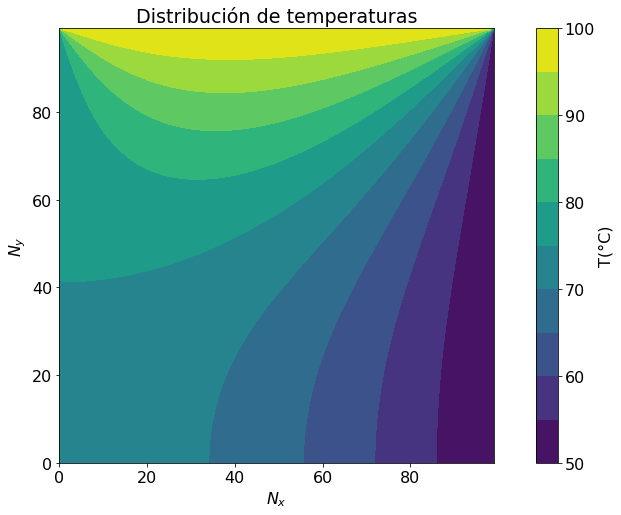

In [6]:
lvl = np.linspace(50, 100, 11)
mapable = plt.contourf(T_matriz, levels=lvl)
plt.gca().set_aspect('equal')
cbar = plt.colorbar(mapable)
cbar.set_label('T(°C)')
plt.title('Distribución de temperaturas')
plt.xlabel('$N_x$')
plt.ylabel('$N_y$')
plt.show()

## Flujos

In [7]:
def getheat(T, dx, dy):
    Qx = np.zeros_like(T)
    Qy = np.zeros_like(T)
    N = len(T)
    
    for k in range(N):
        # Borde izq. (A)
        if k%Nx==0:
            Qx[k] = (T[k+1]-T[k])/dx
        # Borde der. (C)
        elif (k+1)%Nx==0:
            Qx[k] = (T[k]-T[k-1])/dx
        # Nodos internos y los otros bordes
        else:
            Qx[k] = (T[k+1]-T[k-1])/(2*dx)
            
    for k in range (N):
        # Borde inf. (B)
        if k<Nx-1:
            Qy[k] = (T[k+Nx]-T[k])/dy
        # Borde sup. (D)
        elif k>Nx*(Ny-1)-1:
            Qy[k] = (T[k]-T[k-Nx])/dy
        # Nodos internos y los otros bordes
        else:
            Qy[k] = (T[k+Nx]-T[k-Nx])/(2*dy)
    
    return Qx, Qy

In [8]:
dx = 1/(Nx-1)
dy = 1/(Ny-1)
Qx, Qy = getheat(T, dx, dy)

In [9]:
x = np.arange(Nx)
y = np.arange(Ny)
X, Y = np.meshgrid(x, y)
Qx_matriz = Qx.reshape(Nx, Ny)
Qy_matriz = Qy.reshape(Nx, Ny)

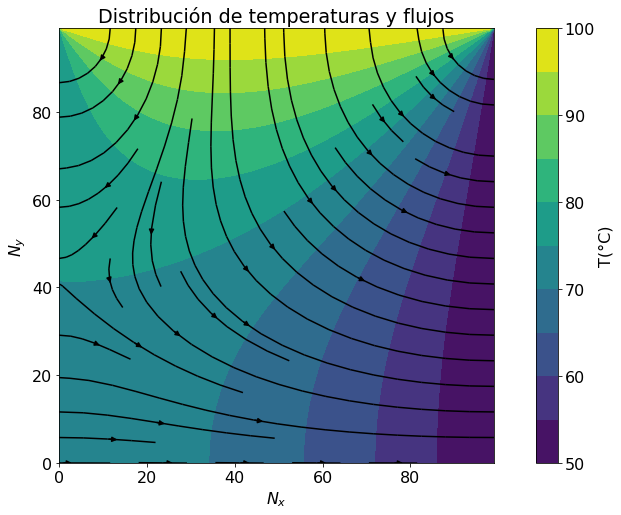

In [10]:
mapable = plt.contourf(T_matriz, levels=lvl)
plt.streamplot(X, Y, -Qx_matriz, -Qy_matriz, color='k', density=0.6)
plt.gca().set_aspect('equal')
cbar = plt.colorbar(mapable)
cbar.set_label('T(°C)')
plt.title('Distribución de temperaturas y flujos')
plt.xlabel('$N_x$')
plt.ylabel('$N_y$')
plt.axis([0, Nx-1, 0, Ny-1])
plt.show()

## Tiempo de cálculo en función del tamaño del sistema

In [34]:
Ns = np.arange(3, 100, 6)

In [35]:
ts = []
for Ni in Ns:
    chapon = chapa(Ni, Ni)
    M, b = chapon.makematrix(CC, TipoCC)
    t1 = time.time()
    T = np.linalg.solve(M, b)
    T_matriz = T.reshape(Ni, Ni)
    t2 = time.time()
    ts.append(t2-t1)

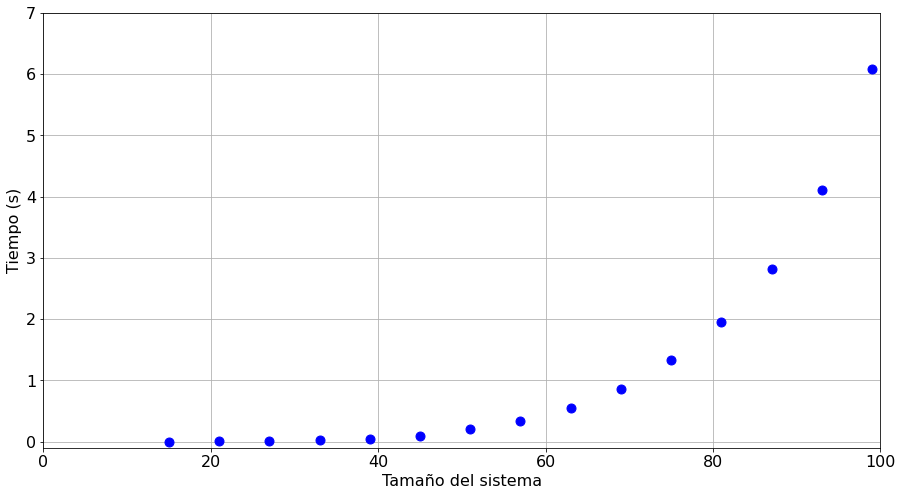

In [36]:
plt.plot(Ns[2:], ts[2:], 'ob', ms=9)
plt.xlabel('Tamaño del sistema')
plt.ylabel('Tiempo (s)')
plt.grid('on')
plt.axis([0, 100, -0.1, 7])
plt.show()